In [1]:
from pennylane import numpy as np
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [2]:
dev = qml.device('default.qubit', wires=4)

In [3]:

PATH_Model2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model2 pre-train/Model2_48.pt'
PATH_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model3 pre-train/Model3_48.pt'

In [4]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load(PATH_Model2))
model3.load_state_dict(torch.load(PATH_Model3))

<All keys matched successfully>

In [5]:
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding1(x1)
    embedding.Noisy_Four_QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(4))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding2(x1)
    embedding.Noisy_Four_QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(4))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

  

QKM without NQE

In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel0 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], False)
        Kernel0[i][j] = x[0]
        Kernel0[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel0)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel0[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel0 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

QKM with PCA-NQE

In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel2 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "PCA-NQE")
        Kernel2[i][j] = x[0]
        Kernel2[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel2)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel2[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel2 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

QKM with NQE

In [6]:
classes = [0,1]
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel3 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "NQE")
        Kernel3[i][j] = x[0]
        Kernel3[j][i] = x[0]

In [ ]:
Kernel_rank = np.linalg.matrix_rank(Kernel3)
Kernel_offD = []
for i in range(N):
    for j in range(i + 1, N):
        Kernel_offD.append(Kernel3[i][j])

Kernel_offD = np.array(Kernel_offD)
Kernel_element_variance = Kernel_offD.std()**2

f = open("Kernel Rank & Variance.txt", 'a')
f.write("\n")
f.write(f"Kernel2 iter {k}\n")
f.write(f"Kernel Rank: {Kernel_rank}\n")
f.write(f"Kernel Variance: {Kernel_element_variance}\n")
f.close()

In [2]:
Kernel0_variance = [0.02381360409226993, 0.022258966444183924, 0.022526021774287405, 0.02165457271512886, 0.022003084072980517]
Kernel2_variance = [0.18937481103532247, 0.18937481103532247, 0.18367656599545923, 0.1877998144550818, 0.18320117679952316]
Kernel3_variance = [0.13692802525123113, 0.13106712723822003, 0.12641167773298584, 0.1279967443496666, 0.13844869478555843]

Kernel0_variance = np.array(Kernel0_variance)
Kernel2_variance = np.array(Kernel2_variance)
Kernel3_variance = np.array(Kernel3_variance)

exp0_train = 0.01794292753845382
exp0_test = 0.019673749305534293
exp2_train = 0.14135069046185675
exp2_test = 0.14250309189831342
exp3_train = 0.13178034856598564
exp3_test = 0.13071623172235433

print(np.sqrt(exp0_train), np.sqrt(exp0_test), np.sqrt(exp2_train), np.sqrt(exp2_test), np.sqrt(exp3_train), np.sqrt(exp3_test), )

0.13395121327727427 0.1402631430759139 0.3759663421928308 0.377495817060684 0.36301563129703607 0.3615469979440492


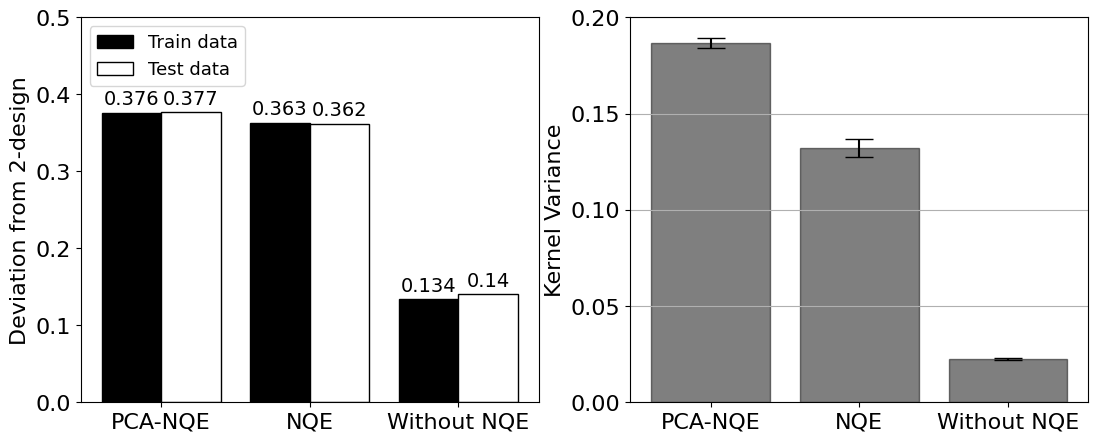

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 5]
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    X = ("PCA-NQE", "NQE", "Without NQE",)
    expressibility = {
        'Train data': (0.376, 0.363, 0.134),
        'Test data': (0.377, 0.362, 0.140),
    }
    Kernel_Variance = {
        'Kernel_Variance': (Kernel0_variance.mean(), Kernel2_variance.mean(), 
                            Kernel3_variance.mean())
    }

x = np.arange(len(X))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


for attribute, measurement in expressibility.items():
    if attribute == 'Train data':
        color = "black"
    else:
        color = "white"
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
    ax1.bar_label(rects, padding=3, fontsize=14)
    multiplier += 1

#x = np.arange(len(X))  # the label locations
#width = 0.25 # the width of the bars
#multiplier = 0

#for attribute, measurement in Kernel_Variance.items():
#    if attribute == 'Kernel_Variance':
#        color = "white"
#    else:
#        color = "white"
#    offset = width * multiplier
#    rects = ax2.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
#    ax2.bar_label(rects,padding=3, fontsize=10)
#    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Deviation from 2-design')
#ax1.set_title('Expressibility')
ax1.set_xticks(x + width - 0.2, X)
ax1.legend(loc='upper left', ncols=1, fontsize=13)
ax1.set_ylim(0, 0.5)

x_pos = np.arange(3)
y = [Kernel2_variance.mean(), Kernel3_variance.mean(), Kernel0_variance.mean()]
error = [Kernel2_variance.std(), Kernel3_variance.std(), Kernel0_variance.std()]
ax2.bar(x_pos, y, yerr=error, align='center', alpha=0.5, color='black', edgecolor='black',ecolor='black', capsize=10)
ax2.set_ylabel('Kernel Variance')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(X)
#ax2.set_title('Kernel Variance')
ax2.set_yticks([0,0.05,0.1,0.15, 0.2])
ax2.yaxis.grid(True)
#ax2.set_ylabel('Kernel Variance')
#ax2.set_title('Kernel Variance')
#ax2.set_xticks(x + width - 0.25, X)
#ax2.set_ylim(0, 0.5)

plt.savefig("Expressibility.pdf")
plt.show()
